In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string
import re
from gensim.models import KeyedVectors
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Flatten
from keras.optimizers import Adam
from gensim.models import KeyedVectors
from keras.layers import Reshape
import matplotlib.pyplot as plt
from keras.callbacks import History
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Download NLTK resources
# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('wordnet')

In [2]:
# Load your dataset from CSV
file_path = r'C:\Users\shahrooz\Desktop\NeuralNetwork\HW4\twitter-suicidal_data.csv'
df = pd.read_csv(file_path)

# Extract text and labels
texts = df.iloc[:, 0].values
labels = df.iloc[:, 1].values
Solid_Text = texts.copy()

In [3]:
def preprocess_text(text):
    # 1. Lowercasing
    text = text.lower()
    # 2. Concatenating
    text = ' '.join([word for word in word_tokenize(text) if word.isalpha()])
    # 3. Removal of Punctuations
    text = text.translate(str.maketrans('', '', string.punctuation))
    # 4. Removal of Stop Words and Special Characters
    stop_words = set(stopwords.words('english'))
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word.isalpha() and word not in stop_words]
    # 5. Filter non-vocabulary words using Word2Vec (300d)
 #   tokens = [word for word in tokens if word in word2vec_model.vocab]
    # 6. Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    # Join the tokens back into a single string
    processed_text = ' '.join(tokens)
    return processed_text
# Apply preprocessing to all texts
texts = [preprocess_text(text) for text in texts]

In [4]:
print(Solid_Text[0])
print(texts[0])
print(type(labels))
print(type(texts))

my life is meaningless i just want to end my life so badly my life is completely empty and i dont want to have to create meaning in it creating meaning is pain how long will i hold back the urge to run my car head first into the next person coming the opposite way when will i stop feeling jealous of tragic characters like gomer pile for the swift end they were able to bring to their lives
life meaningless want end life badly life completely empty dont want create meaning creating meaning pain long hold back urge run car head first next person coming opposite way stop feeling jealous tragic character like gomer pile swift end able bring life
<class 'numpy.ndarray'>
<class 'list'>


In [5]:
# Print the 1st and 2nd members of 'texts' after preprocessing
# print("Text before preprocessing (1st member):")
# print(Solid_Text[5371])
# print(texts[5371])
# Print the 1st and 2nd members of 'texts' after preprocessing
# print("Text before preprocessing (2nd member):")
# print(Solid_Text[5460])
# print("Text after preprocessing (2nd member):")
# print(texts[5460])

In [6]:
# Load pre-trained Word2Vec vectors
word2vec_path = r'C:\Users\shahrooz\Desktop\NeuralNetwork\HW4\GoogleNews-vectors-negative300.bin'
word2vec_model = KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

In [7]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(texts, labels, test_size=0.2, random_state=42)
# Tokenize and pad sequences
max_words = 500
max_len = 70
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)
# Create embedding matrix
embedding_matrix = np.zeros((max_words, 300))  # assuming 300-dimensional vectors
for word, i in tokenizer.word_index.items():
    if i < max_words and word in word2vec_model:
        embedding_matrix[i] = word2vec_model[word]
# Build Stacked CNN - 2 Layer LSTM model with pre-trained Word2Vec vectors
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=300, input_length=max_len, weights=[embedding_matrix], trainable=False))
model.add(Conv1D(64, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Reshape((-1, 64)))
model.add(LSTM(100, return_sequences=True))
model.add(LSTM(50))
#model.add(Dense(2, activation='softmax'))  # Assuming 2 classes (Suicidal and Non-Suicidal)
model.add(Dense(1, activation='sigmoid'))  # Output a single unit for binary classification

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
# Print model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 70, 300)           150000    
                                                                 
 conv1d (Conv1D)             (None, 70, 64)            57664     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 35, 64)           0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 2240)              0         
                                                                 
 dropout (Dropout)           (None, 2240)              0         
                                                                 
 reshape (Reshape)           (None, 35, 64)            0         
                                                        

Epoch 1/20
92/92 [==============================] - 24s 143ms/step - loss: 0.3569 - accuracy: 0.8468 - val_loss: 0.3001 - val_accuracy: 0.8890
Epoch 2/20
92/92 [==============================] - 11s 119ms/step - loss: 0.2806 - accuracy: 0.8927 - val_loss: 0.2608 - val_accuracy: 0.9006
Epoch 3/20
92/92 [==============================] - 11s 117ms/step - loss: 0.2489 - accuracy: 0.9015 - val_loss: 0.2485 - val_accuracy: 0.9082
Epoch 4/20
92/92 [==============================] - 10s 109ms/step - loss: 0.2125 - accuracy: 0.9143 - val_loss: 0.2185 - val_accuracy: 0.9109
Epoch 5/20
92/92 [==============================] - 9s 100ms/step - loss: 0.1960 - accuracy: 0.9208 - val_loss: 0.2189 - val_accuracy: 0.9082
Epoch 6/20
92/92 [==============================] - 9s 103ms/step - loss: 0.1787 - accuracy: 0.9272 - val_loss: 0.2153 - val_accuracy: 0.9184
Epoch 7/20
92/92 [==============================] - 11s 115ms/step - loss: 0.1051 - accuracy: 0.9602 - val_loss: 0.2416 - val_accuracy: 0.9109
E

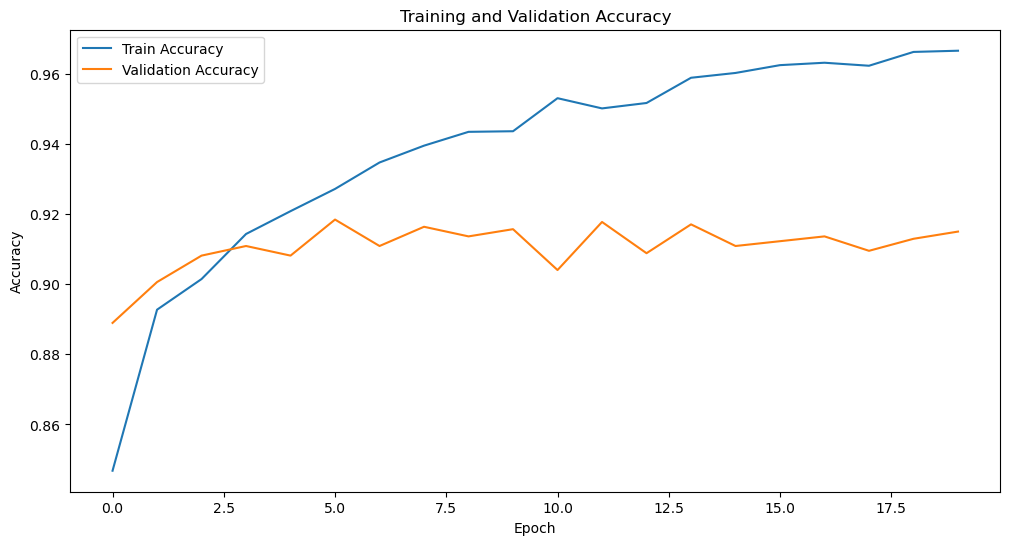

In [8]:
# Train the model and record the history for plotting
history = model.fit(X_train_pad, y_train, epochs=20, batch_size=64, validation_split=0.2)

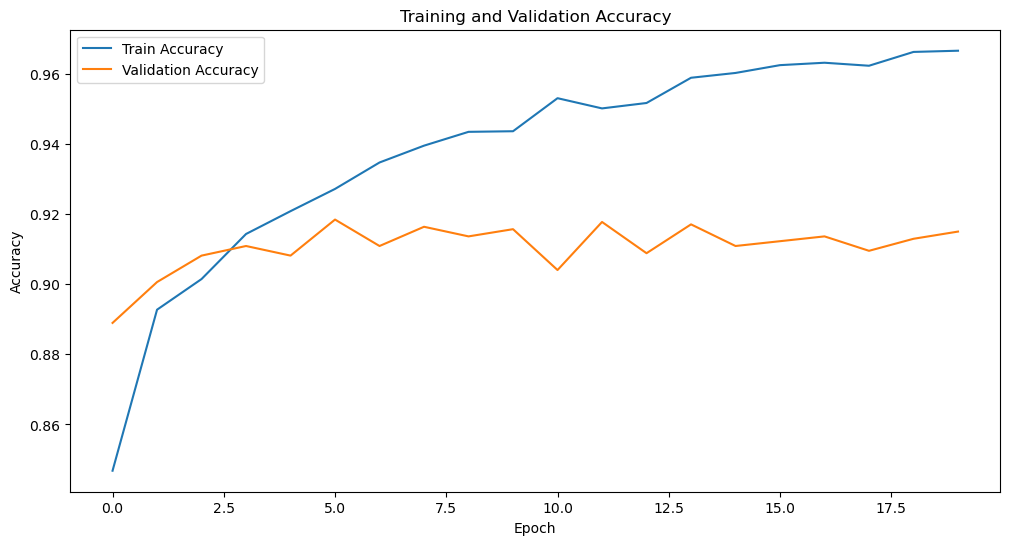

In [13]:
# Plot training and validation accuracy per epoch
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

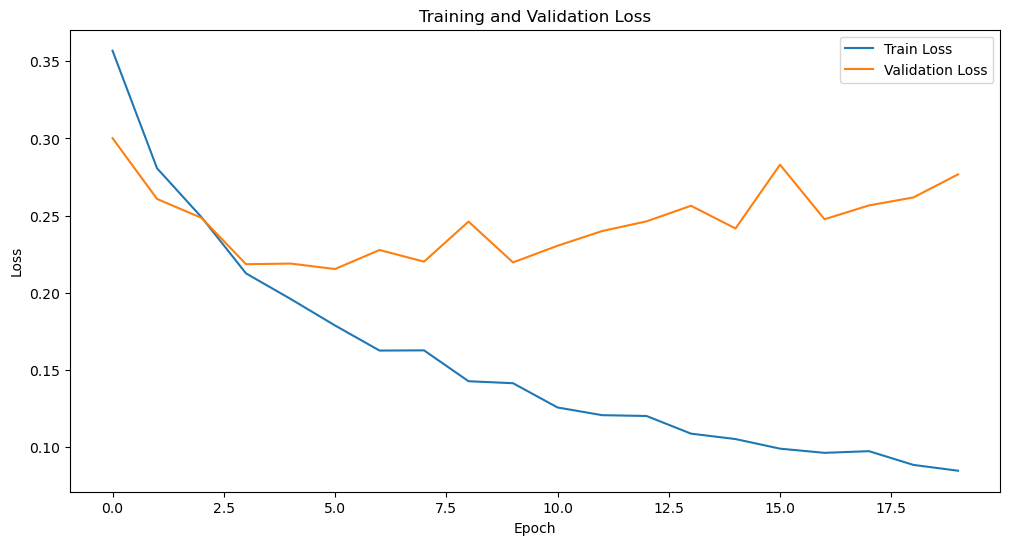

In [11]:
# Plot training and validation loss per epoch
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [9]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test_pad, y_test)
print(f'Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}')

57/57 [==============================] - 1s 21ms/step - loss: 0.3043 - accuracy: 0.9134
Test Loss: 0.3043, Test Accuracy: 0.9134


In [12]:
# Evaluate the model on the test data
evaluation = model.evaluate(X_test_pad, y_test)

# Extract metrics from the evaluation results
loss, accuracy = evaluation
print(f'Loss: {loss:.4f}')
print(f'Accuracy: {accuracy:.4f}')

# Predictions
y_pred_probs = model.predict(X_test_pad)

# Convert probabilities to class labels (0 or 1)
y_pred = (y_pred_probs > 0.5).astype(int)

# Calculate additional metrics
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-score: {f1:.4f}')

57/57 [==============================] - 2s 34ms/step - loss: 0.3043 - accuracy: 0.9134
Loss: 0.3043
Accuracy: 0.9134
57/57 [==============================] - 5s 49ms/step
Precision: 0.9273
Recall: 0.8720
F1-score: 0.8988


Epoch 1/20
92/92 [==============================] - 36s 324ms/step - loss: 0.3673 - accuracy: 0.8340 - val_loss: 0.2839 - val_accuracy: 0.8951
Epoch 2/20
92/92 [==============================] - 17s 181ms/step - loss: 0.2760 - accuracy: 0.8908 - val_loss: 0.2694 - val_accuracy: 0.9034
Epoch 3/20
92/92 [==============================] - 17s 183ms/step - loss: 0.2518 - accuracy: 0.9013 - val_loss: 0.2569 - val_accuracy: 0.9020
Epoch 4/20
92/92 [==============================] - 16s 177ms/step - loss: 0.2328 - accuracy: 0.9092 - val_loss: 0.2377 - val_accuracy: 0.9082
Epoch 5/20
92/92 [==============================] - 14s 151ms/step - loss: 0.2245 - accuracy: 0.9073 - val_loss: 0.2329 - val_accuracy: 0.9061
Epoch 6/20
92/92 [==============================] - 15s 160ms/step - loss: 0.2191 - accuracy: 0.9102 - val_loss: 0.2312 - val_accuracy: 0.9116
Epoch 7/20
92/92 [==============================] - 23s 251ms/step - loss: 0.2043 - accuracy: 0.9178 - val_loss: 0.2349 - val_accuracy: 0.9075

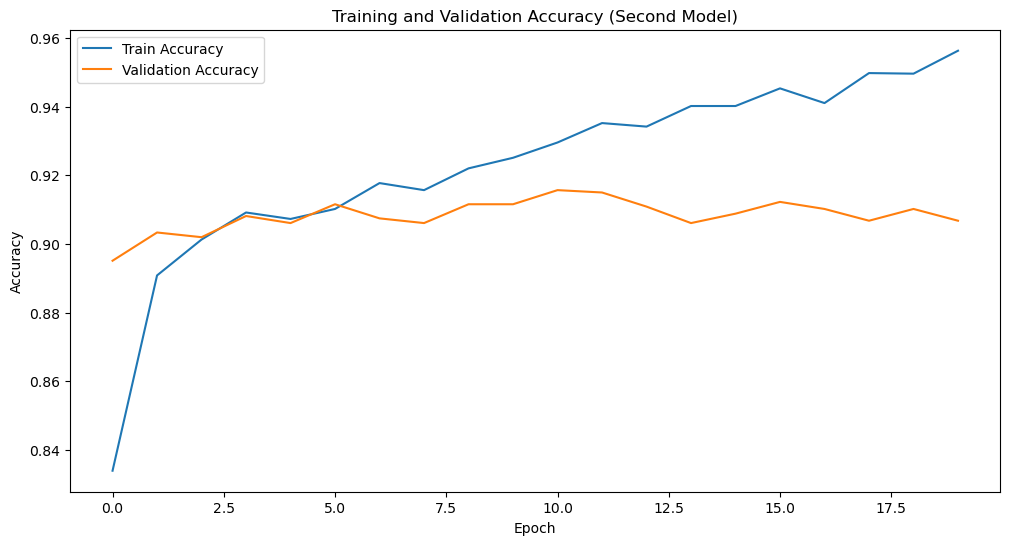

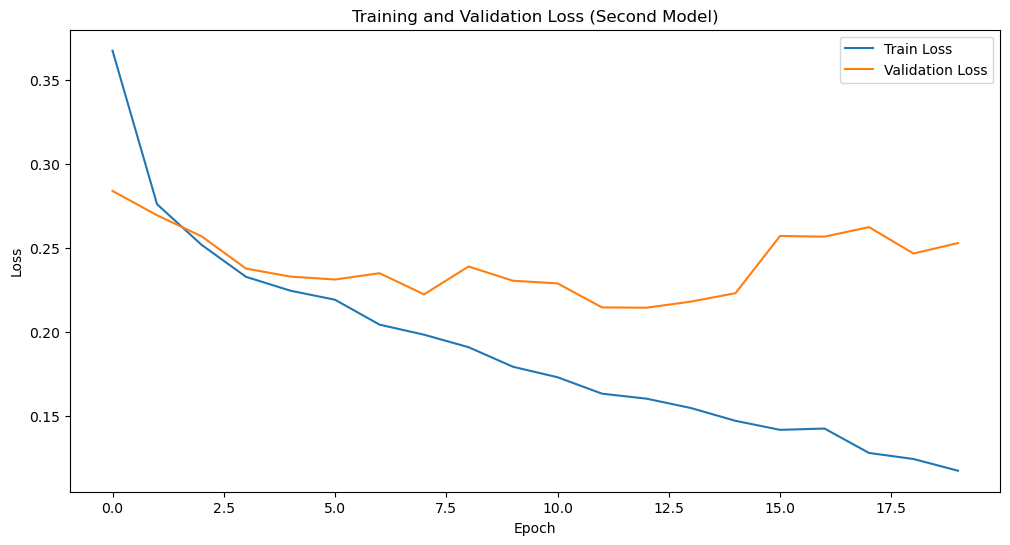

57/57 [==============================] - 2s 32ms/step - loss: 0.3052 - accuracy: 0.8882

Second Model Metrics:
Loss: 0.3052
Accuracy: 0.8882
57/57 [==============================] - 4s 37ms/step
Precision: 0.8724
Recall: 0.8745
F1-score: 0.8734


In [15]:
## LSTM
# Build the second model
second_model = Sequential()
second_model.add(Embedding(input_dim=max_words, output_dim=300, input_length=max_len, weights=[embedding_matrix], trainable=False))
second_model.add(LSTM(100))
second_model.add(Dropout(0.5))
second_model.add(Dense(1, activation='sigmoid'))
# Compile the second model
second_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the second model and record history
history_second_model = second_model.fit(X_train_pad, y_train, epochs=20, batch_size=64, validation_split=0.2)

# Plot accuracy per epoch for training and validation
plt.figure(figsize=(12, 6))
plt.plot(history_second_model.history['accuracy'], label='Train Accuracy')
plt.plot(history_second_model.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy (Second Model)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss per epoch for training and validation
plt.figure(figsize=(12, 6))
plt.plot(history_second_model.history['loss'], label='Train Loss')
plt.plot(history_second_model.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss (Second Model)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate the second model on the test data
evaluation_second_model = second_model.evaluate(X_test_pad, y_test)
# Extract metrics from the evaluation results
loss_second_model, accuracy_second_model = evaluation_second_model
print(f'\nSecond Model Metrics:')
print(f'Loss: {loss_second_model:.4f}')
print(f'Accuracy: {accuracy_second_model:.4f}')
# Predictions for the second model
y_pred_probs_second_model = second_model.predict(X_test_pad)
y_pred_second_model = (y_pred_probs_second_model > 0.5).astype(int)
# Calculate additional metrics for the second model
precision_second_model = precision_score(y_test, y_pred_second_model)
recall_second_model = recall_score(y_test, y_pred_second_model)
f1_second_model = f1_score(y_test, y_pred_second_model)
print(f'Precision: {precision_second_model:.4f}')
print(f'Recall: {recall_second_model:.4f}')
print(f'F1-score: {f1_second_model:.4f}')


Epoch 1/20
92/92 [==============================] - 50s 316ms/step - loss: 0.3544 - accuracy: 0.8425 - val_loss: 0.2940 - val_accuracy: 0.8794
Epoch 2/20
92/92 [==============================] - 29s 316ms/step - loss: 0.2774 - accuracy: 0.8903 - val_loss: 0.2544 - val_accuracy: 0.8958
Epoch 3/20
92/92 [==============================] - 23s 256ms/step - loss: 0.2525 - accuracy: 0.9040 - val_loss: 0.2609 - val_accuracy: 0.8986
Epoch 4/20
92/92 [==============================] - 25s 275ms/step - loss: 0.2256 - accuracy: 0.9102 - val_loss: 0.2223 - val_accuracy: 0.9109
Epoch 5/20
92/92 [==============================] - 34s 374ms/step - loss: 0.2104 - accuracy: 0.9162 - val_loss: 0.2283 - val_accuracy: 0.9088
Epoch 6/20
92/92 [==============================] - 28s 305ms/step - loss: 0.2026 - accuracy: 0.9200 - val_loss: 0.2310 - val_accuracy: 0.9102
Epoch 7/20
92/92 [==============================] - 29s 315ms/step - loss: 0.1901 - accuracy: 0.9243 - val_loss: 0.2142 - val_accuracy: 0.9068

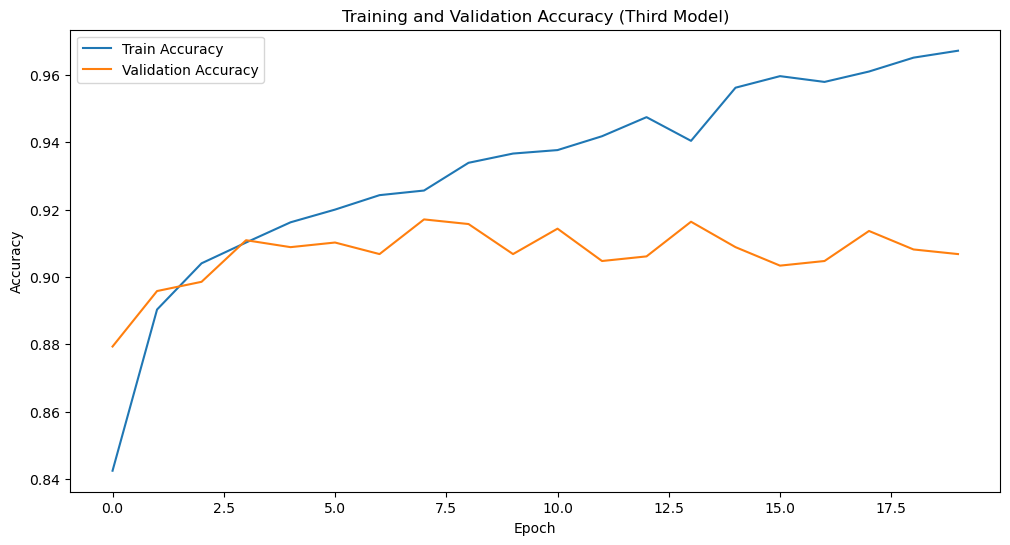

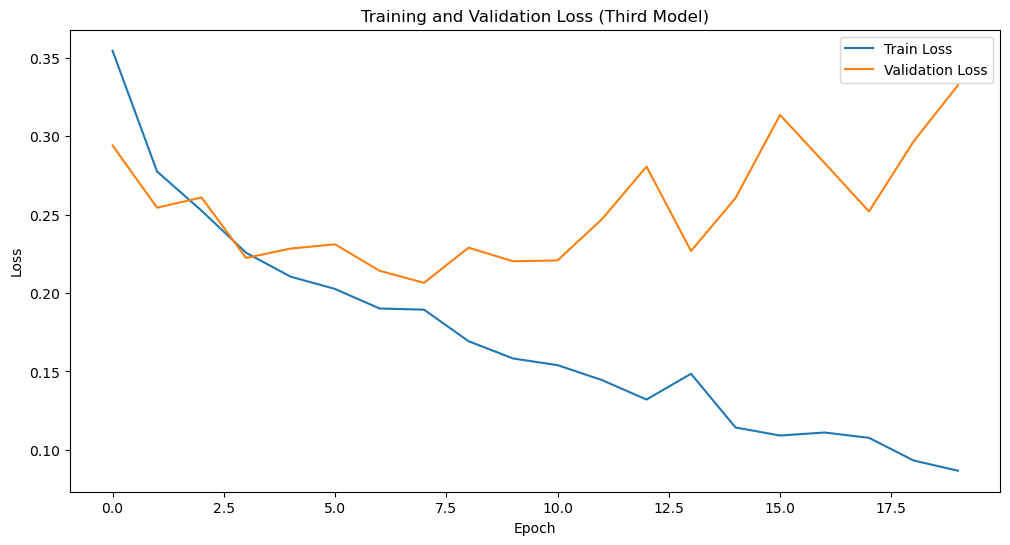

57/57 [==============================] - 4s 73ms/step - loss: 0.4232 - accuracy: 0.8936

Third Model Metrics:
Loss: 0.4232
Accuracy: 0.8936
57/57 [==============================] - 11s 144ms/step
Precision: 0.8872
Recall: 0.8696
F1-score: 0.8783


In [16]:
### 2 Layer LSTM

# Build the third model
third_model = Sequential()
third_model.add(Embedding(input_dim=max_words, output_dim=300, input_length=max_len, weights=[embedding_matrix], trainable=False))
# No Conv1D, MaxPooling1D, or Flatten layers
third_model.add(LSTM(100, return_sequences=True))
third_model.add(LSTM(50))
third_model.add(Dropout(0.5))
third_model.add(Dense(1, activation='sigmoid'))
# Compile the third model
third_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
# Train the third model and record history
history_third_model = third_model.fit(X_train_pad, y_train, epochs=20, batch_size=64, validation_split=0.2)
# Plot accuracy per epoch for training and validation
plt.figure(figsize=(12, 6))
plt.plot(history_third_model.history['accuracy'], label='Train Accuracy')
plt.plot(history_third_model.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy (Third Model)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
# Plot loss per epoch for training and validation
plt.figure(figsize=(12, 6))
plt.plot(history_third_model.history['loss'], label='Train Loss')
plt.plot(history_third_model.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss (Third Model)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
# Evaluate the third model on the test data
evaluation_third_model = third_model.evaluate(X_test_pad, y_test)
# Extract metrics from the evaluation results
loss_third_model, accuracy_third_model = evaluation_third_model
print(f'\nThird Model Metrics:')
print(f'Loss: {loss_third_model:.4f}')
print(f'Accuracy: {accuracy_third_model:.4f}')
# Predictions for the third model
y_pred_probs_third_model = third_model.predict(X_test_pad)
y_pred_third_model = (y_pred_probs_third_model > 0.5).astype(int)
# Calculate additional metrics for the third model
precision_third_model = precision_score(y_test, y_pred_third_model)
recall_third_model = recall_score(y_test, y_pred_third_model)
f1_third_model = f1_score(y_test, y_pred_third_model)
print(f'Precision: {precision_third_model:.4f}')
print(f'Recall: {recall_third_model:.4f}')
print(f'F1-score: {f1_third_model:.4f}')
